In [22]:
# Standard imports 
import collections
import glob
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler
import numpy as np
import time

# Formatting to make the plots look a bit nicer. 
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 3.0})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))
mpl.rc('text', usetex=False)
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['HelveticaNeueThin']})
#plt.tick_params(top=False, bottom=False, right=False, left=False)
tw = 1.5
sns.set_style({"xtick.major.size": 6, "ytick.major.size": 6,
               "xtick.minor.size": 4, "ytick.minor.size": 4,
               'axes.labelsize': 24,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18)
mpl.rc('axes', linewidth=1.75)
plt.gcf().subplots_adjust(bottom=0.15)
sns.set_style({'axes.labelsize': 24})

<Figure size 432x288 with 0 Axes>

In [30]:
def gate(data, firstChannel, secondChannel, lowPercentile, highPercentile):
    """Main function used in the script. 
    Filter (gate) cells based on a percentile gating method. This function
    takes the intersection of cells that are within the lowPercentile and
    highPercentile you set for both channels and returns those cells for 
    further analysis. Channel must match the channel name on your tidy data file."""

    first = np.array(data[firstChannel])
    second = np.array(data[secondChannel])

    firstLow = np.percentile(first, lowPercentile)
    firstHigh = np.percentile(first, highPercentile)
    secondLow = np.percentile(second, lowPercentile)
    secondHigh = np.percentile(second, highPercentile)

    zipped = zip(first, second) 

    gated = []
    ungated = []

    gatingResults = []
    for entry in zipped: 
        if firstLow < entry[0] < firstHigh: 
            if secondLow < entry[1] < secondHigh: 
                gated.append(entry) 
                gatingResults.append(1)
            else: 
                ungated.append(entry)
                gatingResults.append(0)
        else:
            ungated.append(entry)
            gatingResults.append(0)

    gatingResults = np.array(gatingResults)

    data['Gates'] = gatingResults

    return data

In [31]:
def getGates(data, low_percentile, high_percentile, 
             first_channel='FSC-A', second_channel='SSC-A'):
    """It takes data, a csv file location
    with your data in tidy format, low_percentile, your lower threshold, high_percentile,
    your higher threshold, first_channel and second channel. The channels are defaulted to
    FSC-A and SSC-A."""

    # Read in the data
    df = pd.read_csv(data)
    
    # Get the intersection of cells on first channel and second channel.
    gatedOutput = gate(df, first_channel, second_channel, low_percentile, high_percentile)
    return gatedOutput

In [32]:
def plotGating(data, output_name, output_directory, lowPercentile, highPercentile,
              first_channel='FSC-A', second_channel='SSC-A'):
    """ This function is if you want to check what your gating looks like. 
    It is a good idea to run this a few times per dataset to make sure all of the
    flow cytometry data looks accurate. It defaults to assume you want to gate on
    FSC-A and SSC-A, as these are the most likely to be used for 
    "quality assurance."""
    
    df = pd.read_csv(data)
    #mask0 = df['mKate/APC-A'] > 100
    gatedOutput = gate(df, first_channel, second_channel,
        lowPercentile, highPercentile)
    mask = gatedOutput['Gates'] == 1
    
    plt.figure(figsize=(8,8))
    plt.loglog(df[first_channel], df[second_channel], '.', 
        markersize=6, rasterized=True, color='k')
    plt.loglog(gatedOutput[~mask][first_channel], gatedOutput[~mask][second_channel], '.',
    markersize=6, rasterized=True, color='k', basex=10, basey=10)
    plt.loglog(gatedOutput[mask][first_channel], gatedOutput[mask][second_channel], '.',
        markersize=6, rasterized=True, color='b', basex=10, basey=10)
    plt.ylabel(second_channel)
    plt.xlabel(first_channel)
    plt.savefig(output_directory + output_name + '.png')

In [33]:
def generate_csv_with_gates(file_name, output_name, plot_output_name, output_directory,
                           low_percentile, high_percentile, first_channel, second_channel):
    
    data = getGates(file_name, low_percentile, high_percentile)
    plotGating(file_name, output_name, plot_output_name, low_percentile, high_percentile)
    
    # Get all of the cells that have passed gating
    # NOTE - it's frequently a good idea to remove all cells with a negative fluorescence. 
    # This was recommended by Justin Bois, so you know that it is as good as Gospel.
    data_gated = data.loc[(data['Gates'] == 1)]
    
    # Write the data to a csv 
    data_gated.to_csv(output_directory + output_name + '.csv', index=False)

In [34]:
def get_all_gates(file_directory, output_directory, plot_output_name,
                  low_percentile, high_percentile, wells, 
                  first_channel='FSC-A', second_channel='SSC-A'):
    all_files = glob.glob(file_directory)
    all_files.sort()
    for i in range(0, len(all_files)):
        generate_csv_with_gates(all_files[i], wells[i],
                                plot_output_name, output_directory, low_percentile,
                               high_percentile, first_channel, second_channel)

In [35]:
wells = ['A01', 'B01', 'C01', 'D01', 'E01', 'F01', 'G01', 'H01',
         'A02', 'B02', 'C02', 'D02', 'E02', 'F02', 'G02', 'H02',
         'A03', 'B03', 'C03', 'D03', 'E03', 'F03', 'G03', 'H03',
         'A04', 'B04', 'C04', 'D04', 'E04', 'F04', 'G04', 'H04',
         'A05', 'B05', 'C05', 'D05', 'E05', 'F05', 'G05', 'H05',
         'A06', 'B06', 'C06', 'D06', 'E06', 'F06', 'G06', 'H06',
         'A07', 'B07', 'C07', 'D07', 'E07', 'F07', 'G07', 'H07',
         'A08', 'B08', 'C08', 'D08', 'E08', 'F08', 'G08', 'H08',
         'A09', 'B09', 'C09', 'D09', 'E09', 'F09', 'G09', 'H09',
         'A10', 'B10', 'C10', 'D10', 'E10', 'F10', 'G10', 'H10',
         'A11', 'B11', 'C11', 'D11', 'E11', 'F11', 'G11', 'H11',
         'A12', 'B12', 'C12', 'D12', 'E12', 'F12', 'G12', 'H12']

/Users/andrewhalleran/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


52.54355502128601


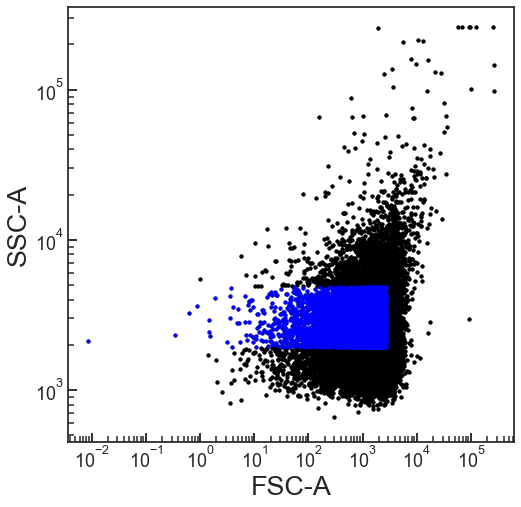

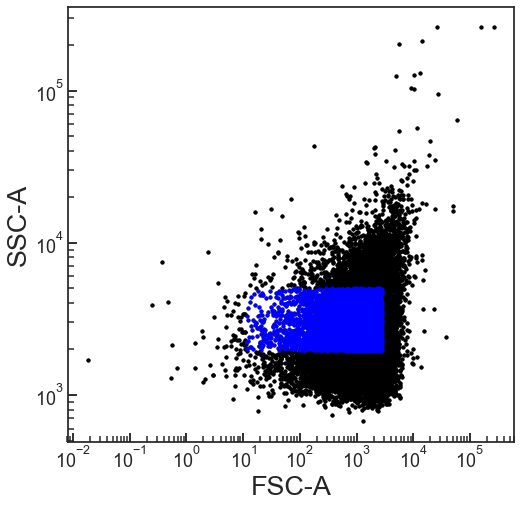

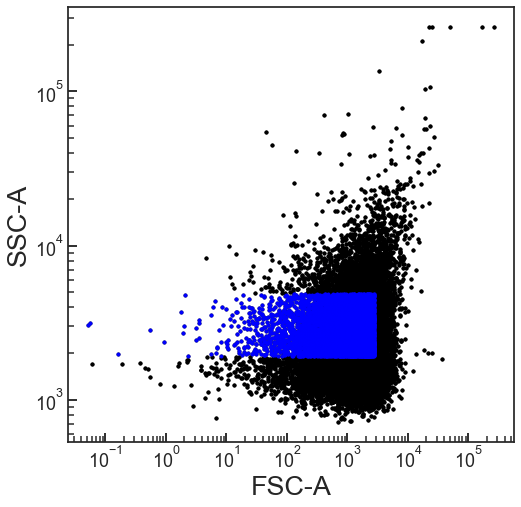

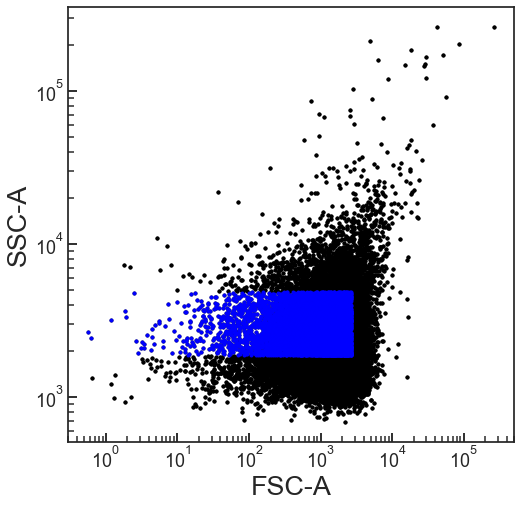

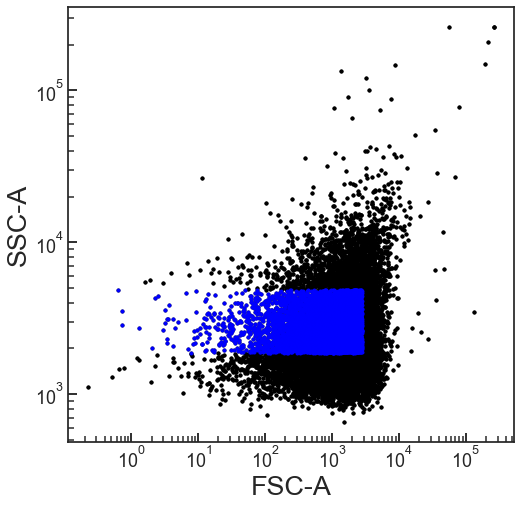

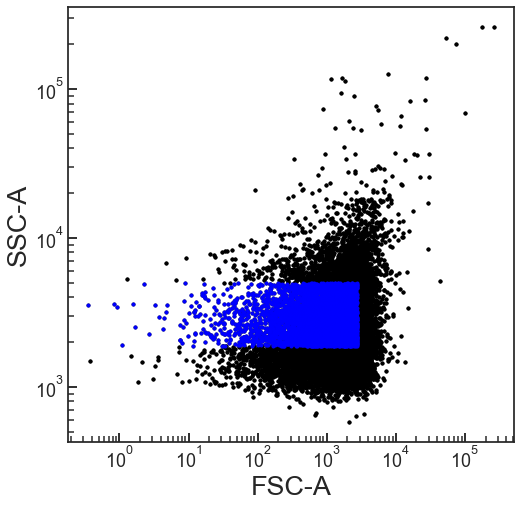

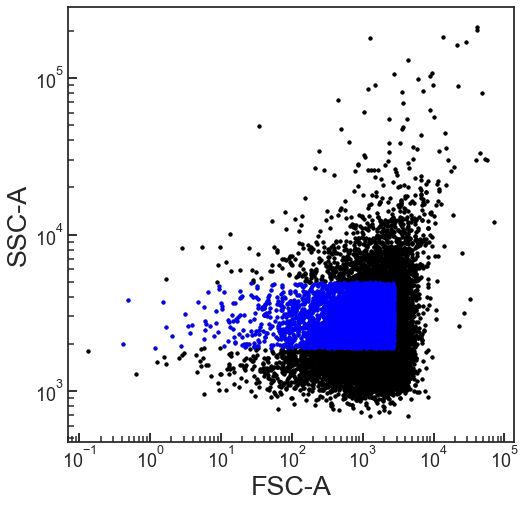

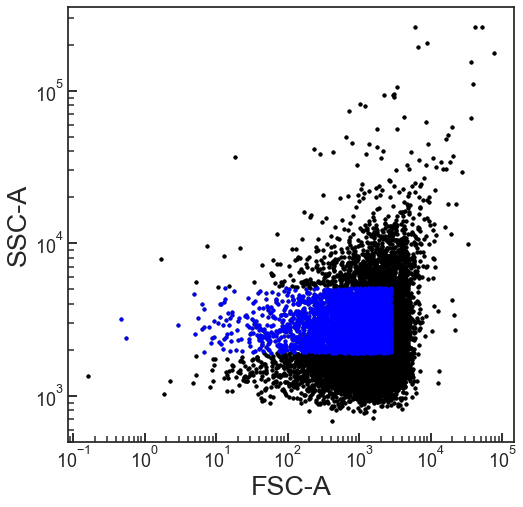

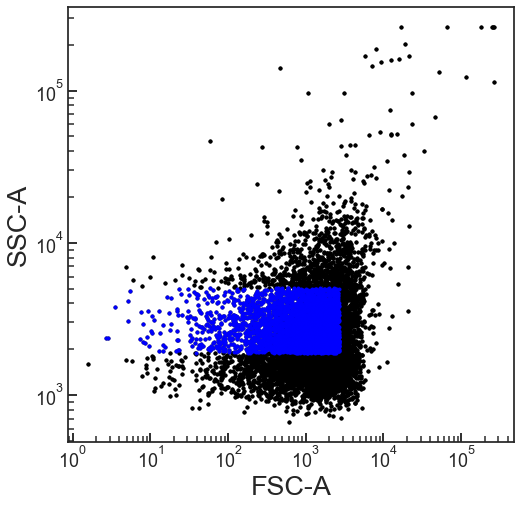

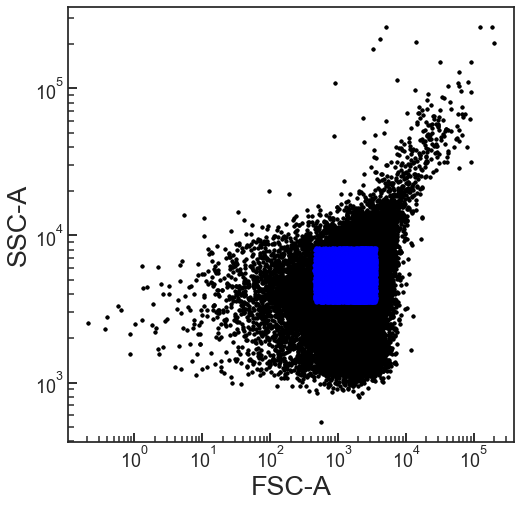

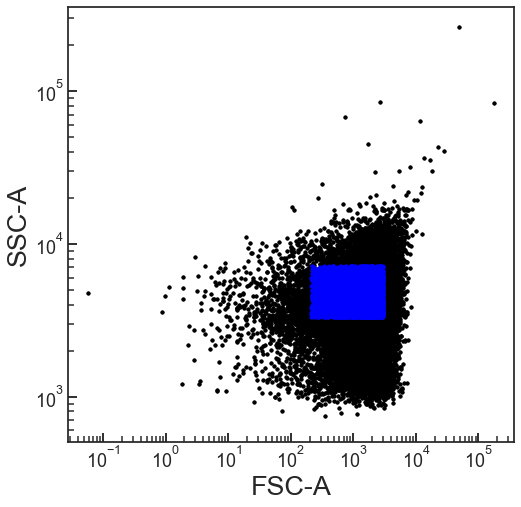

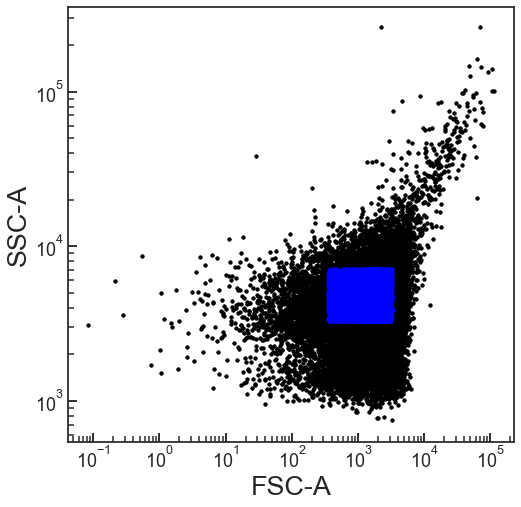

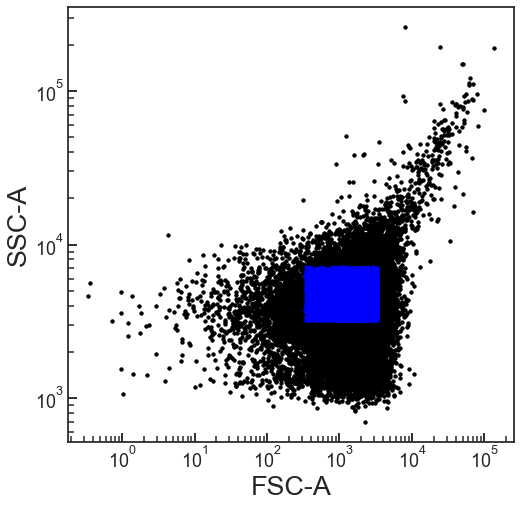

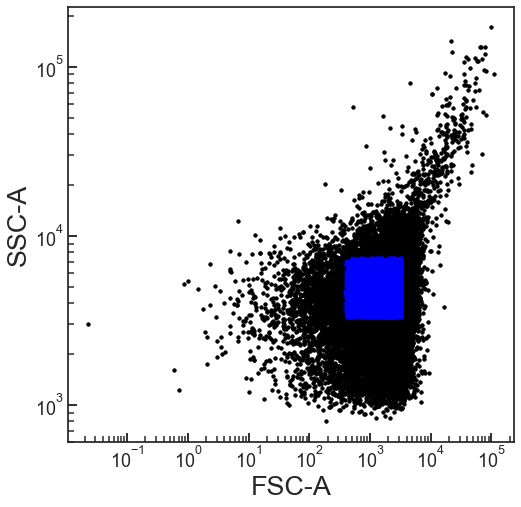

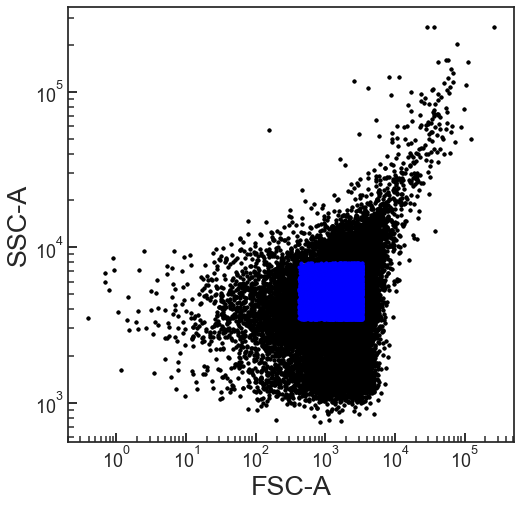

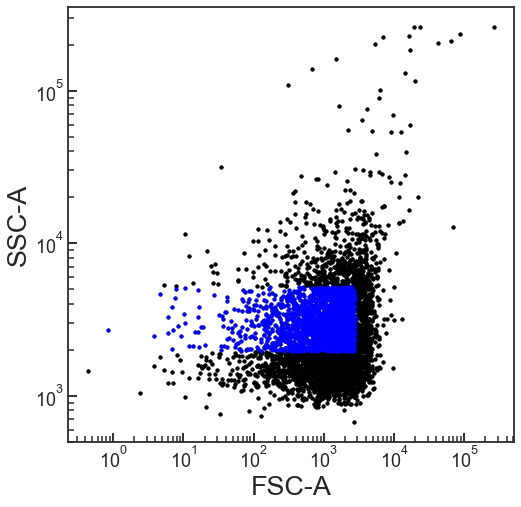

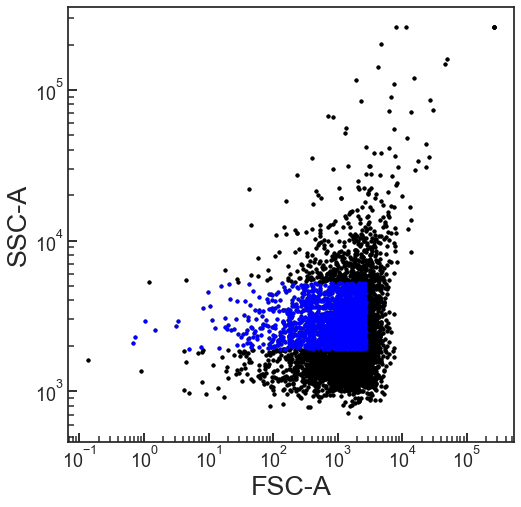

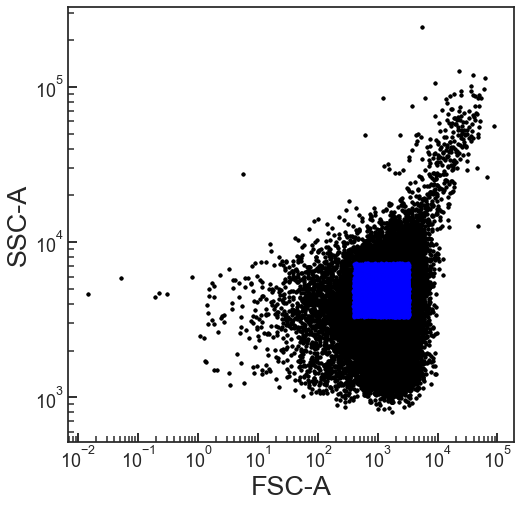

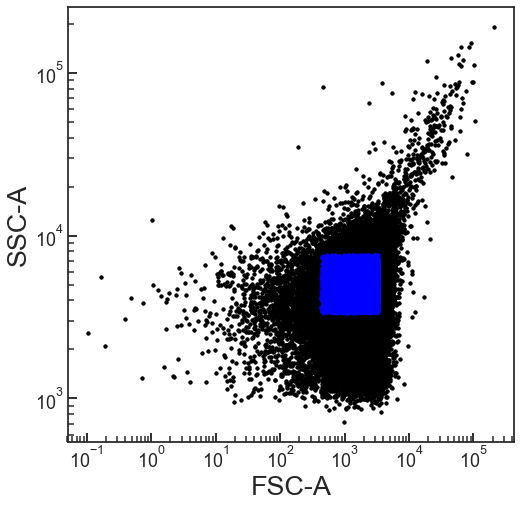

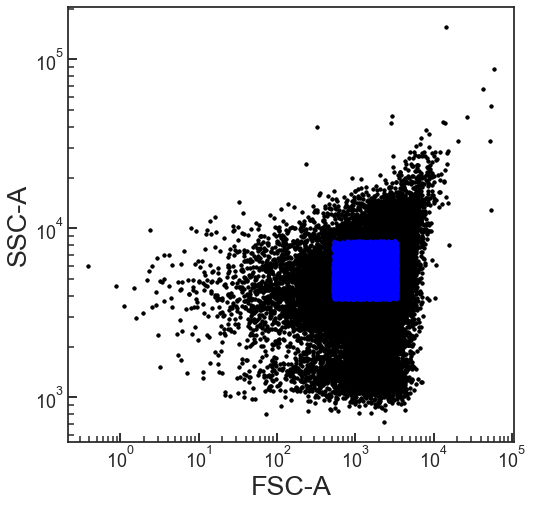

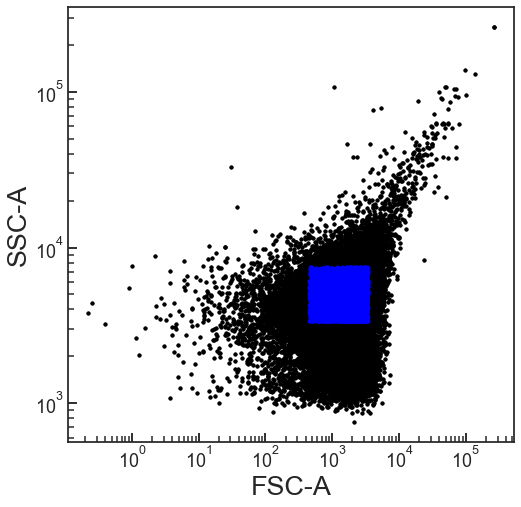

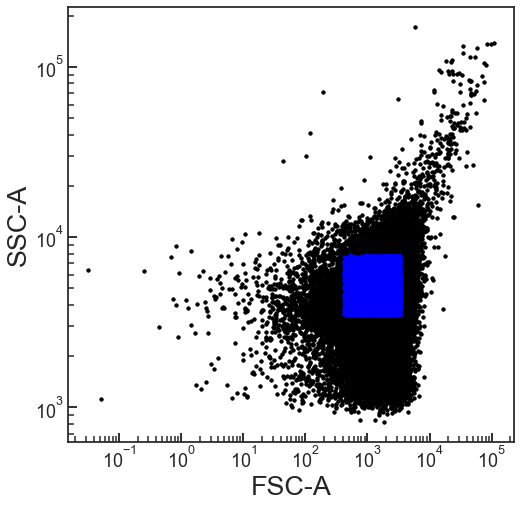

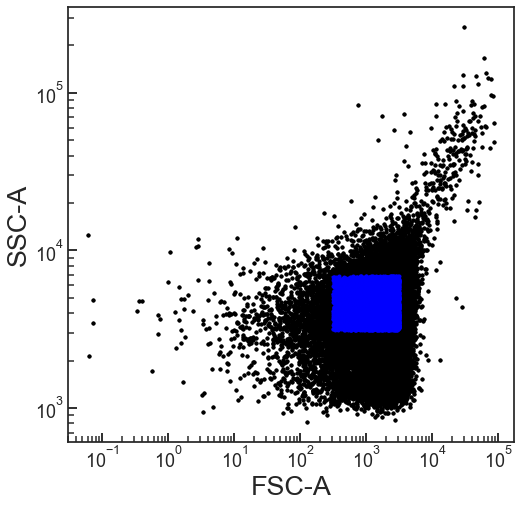

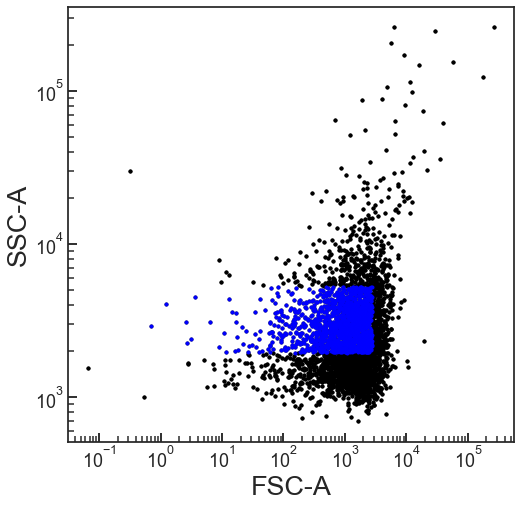

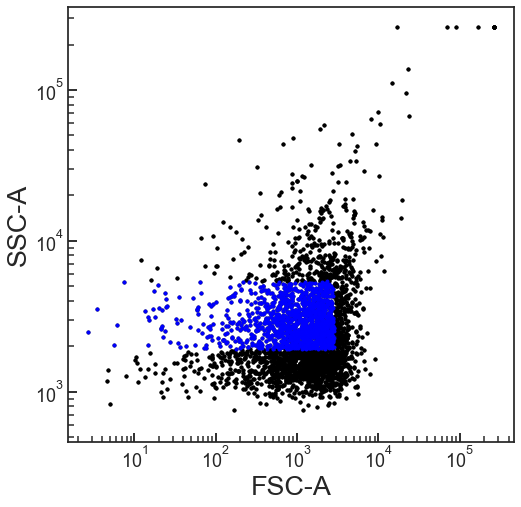

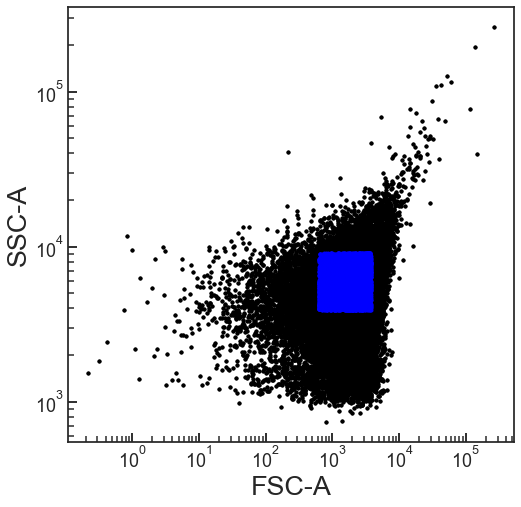

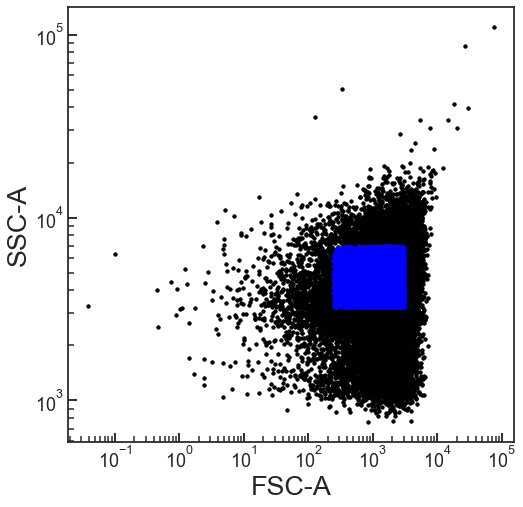

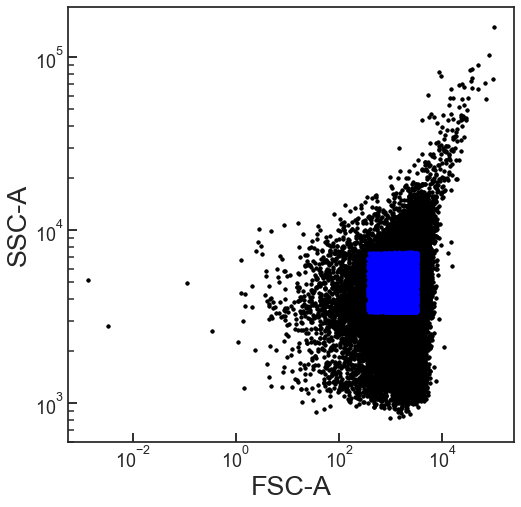

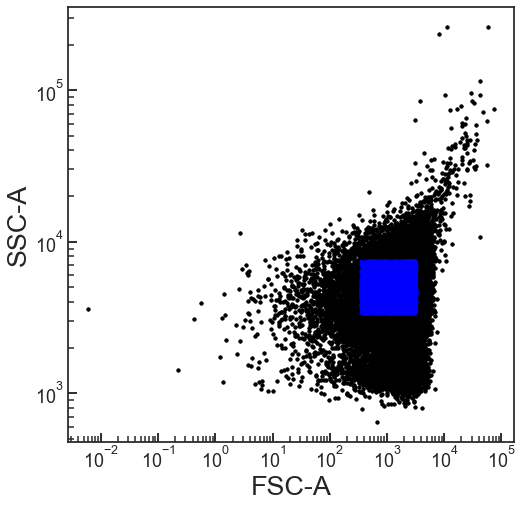

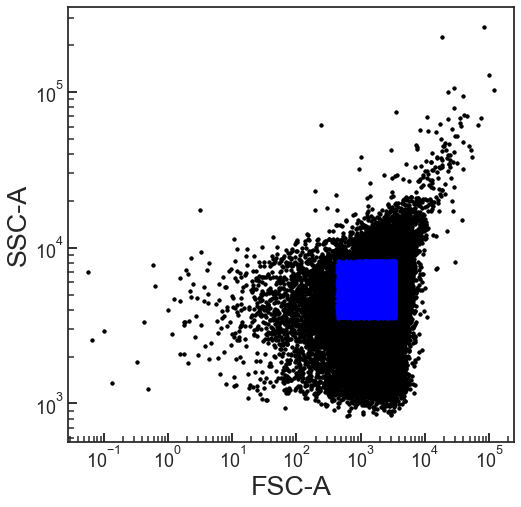

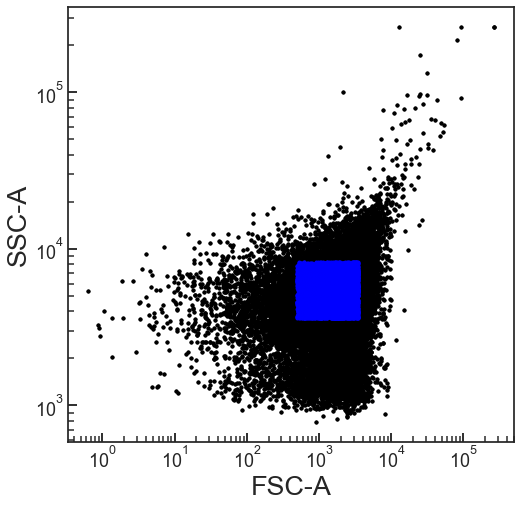

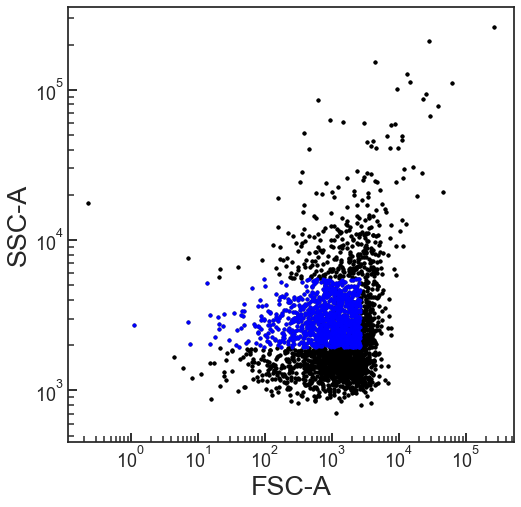

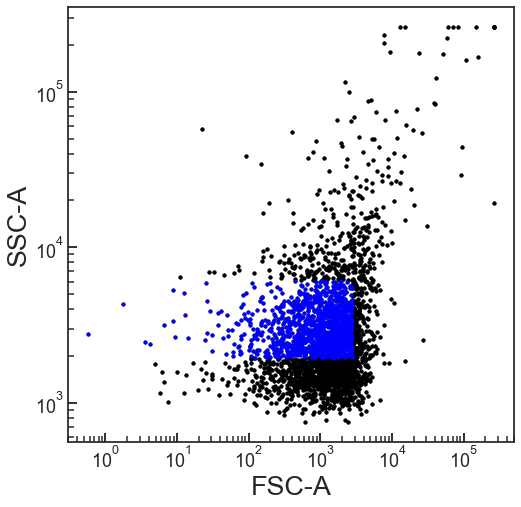

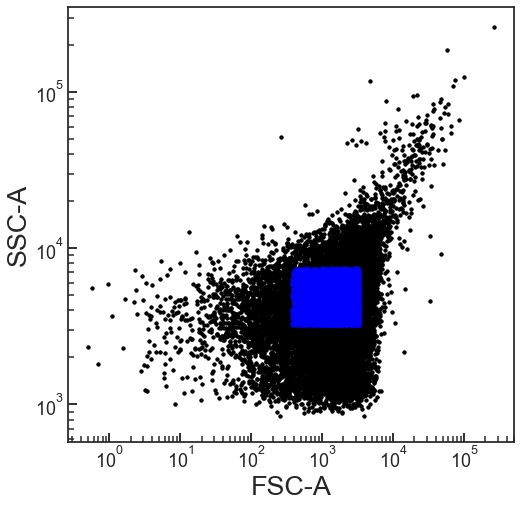

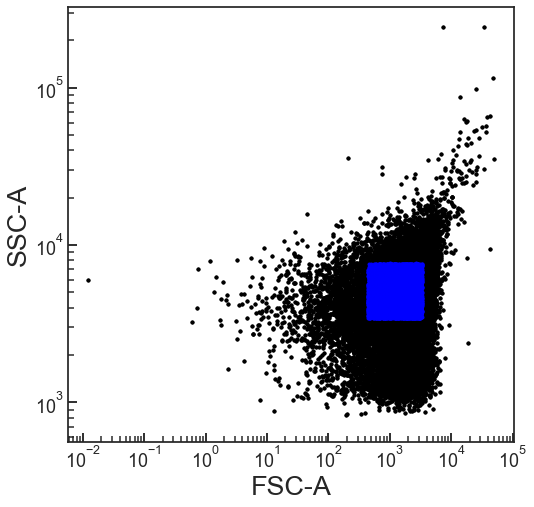

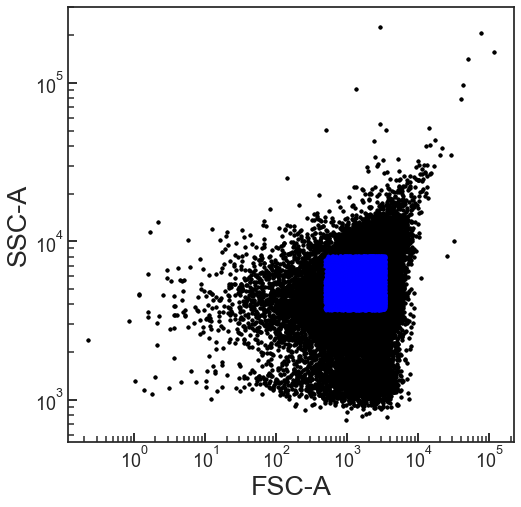

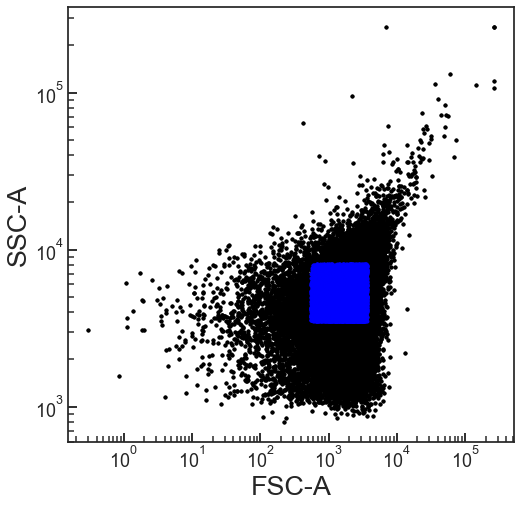

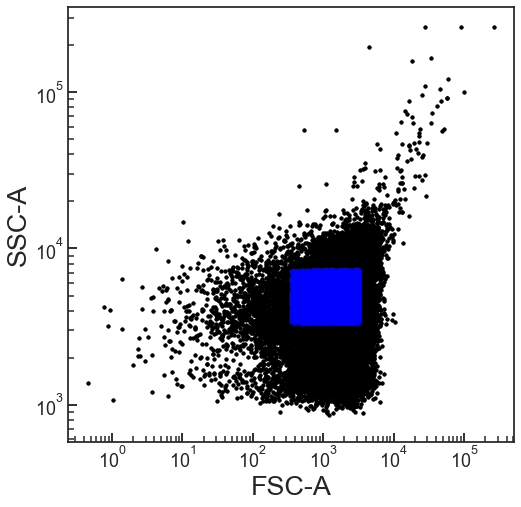

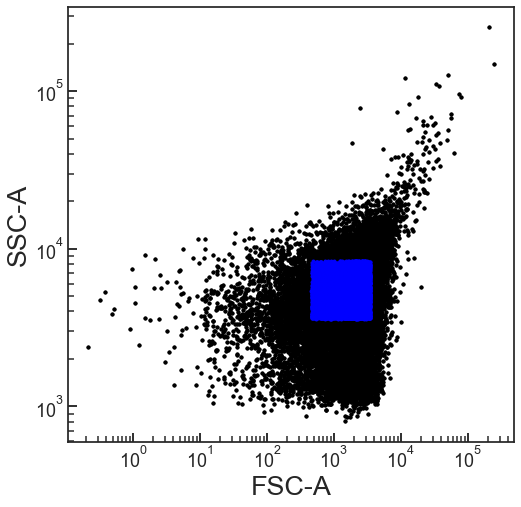

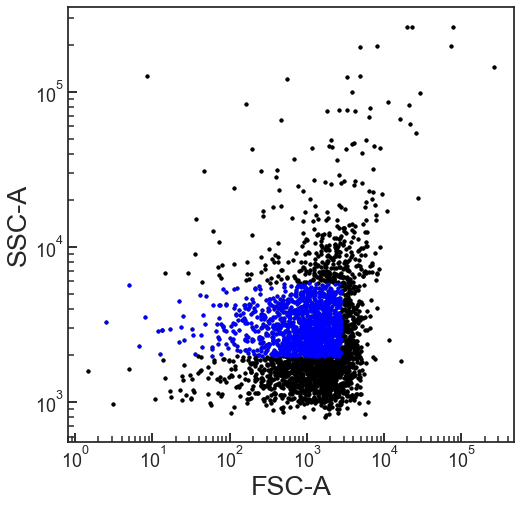

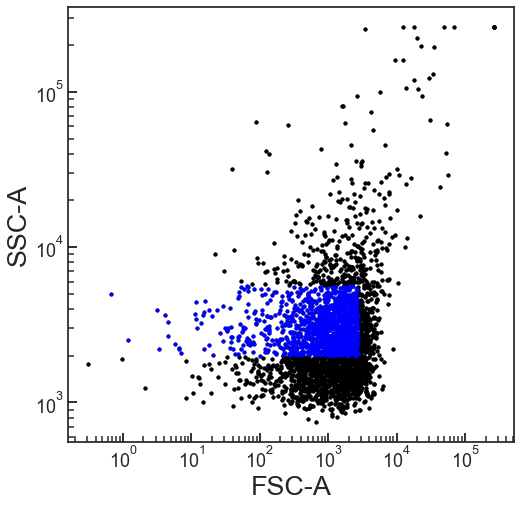

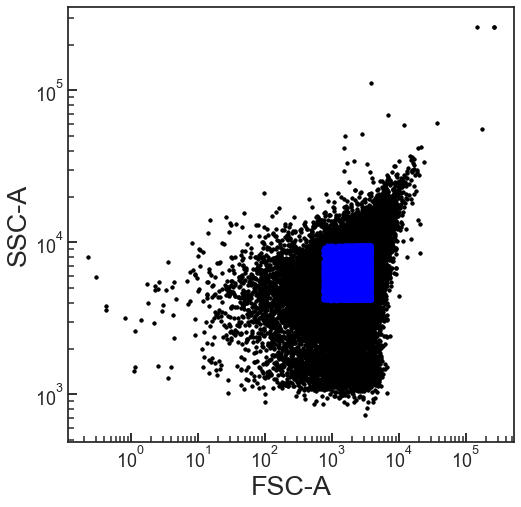

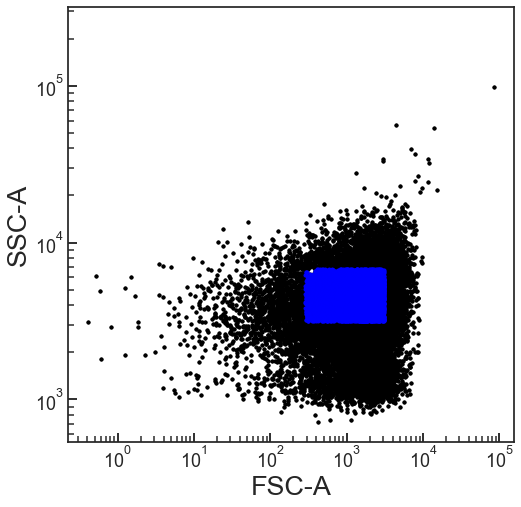

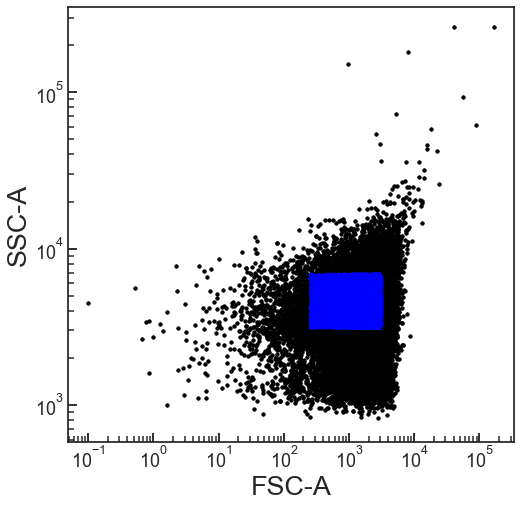

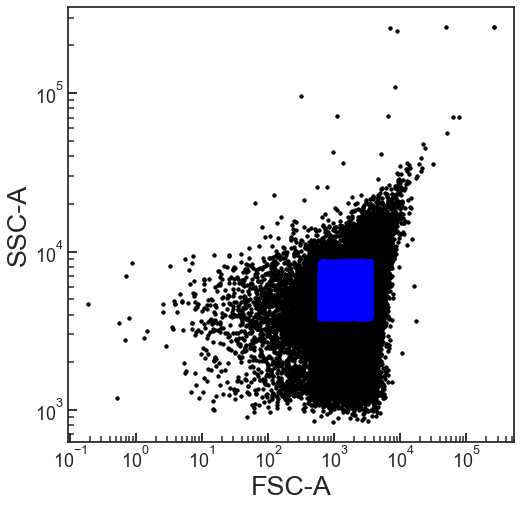

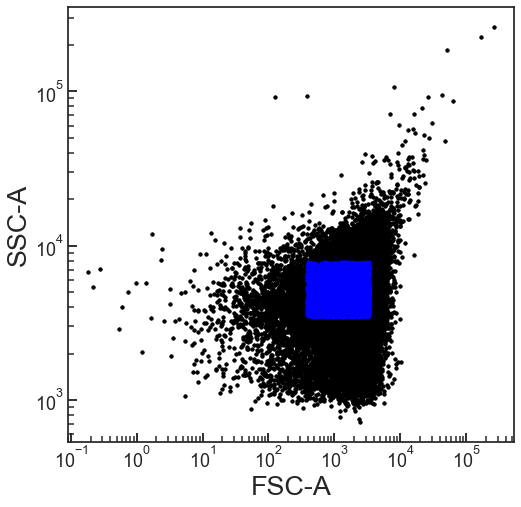

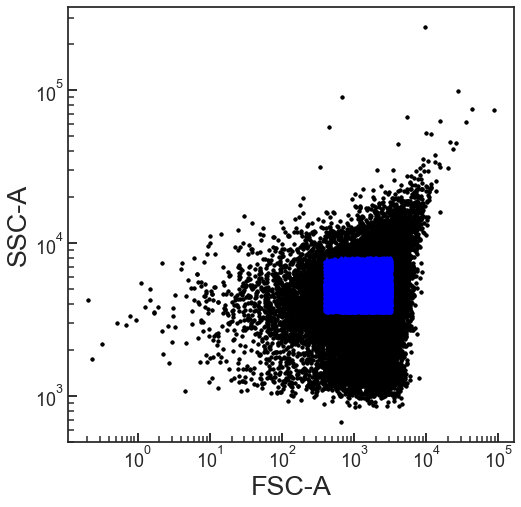

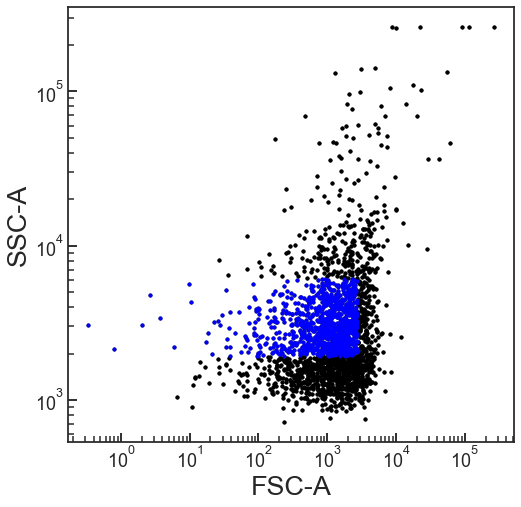

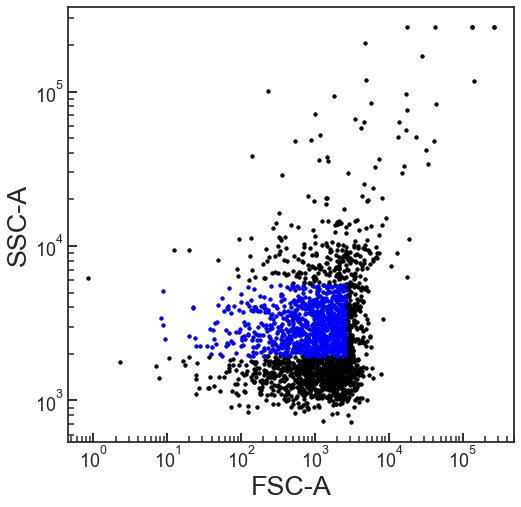

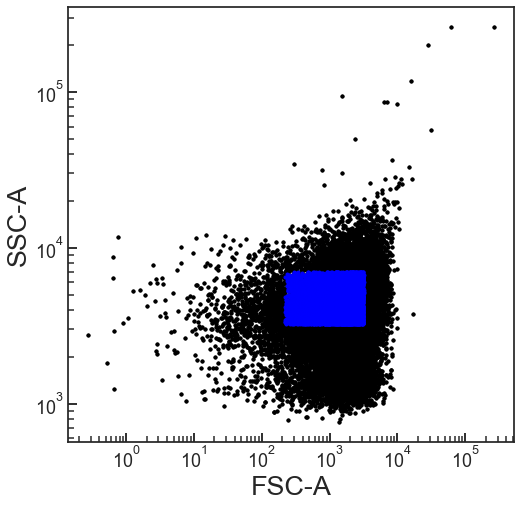

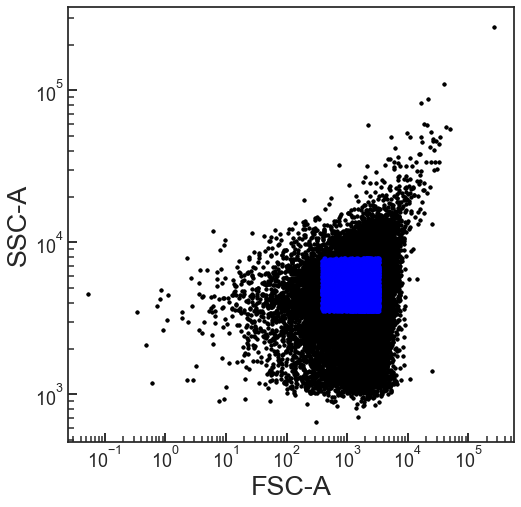

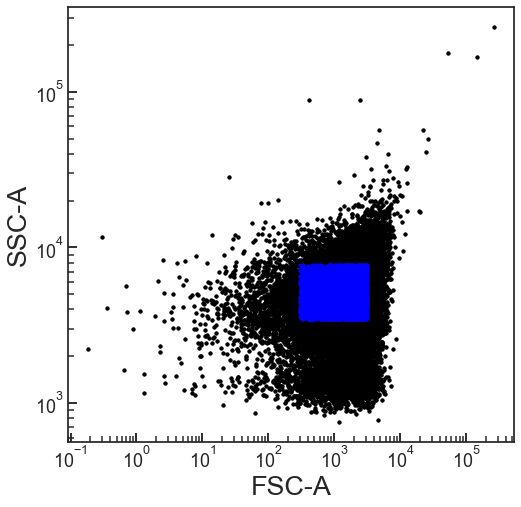

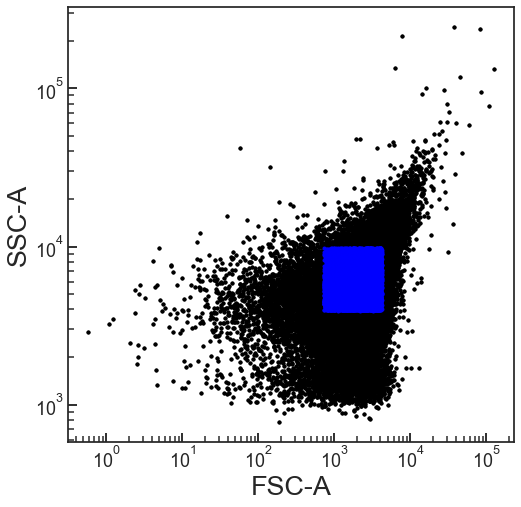

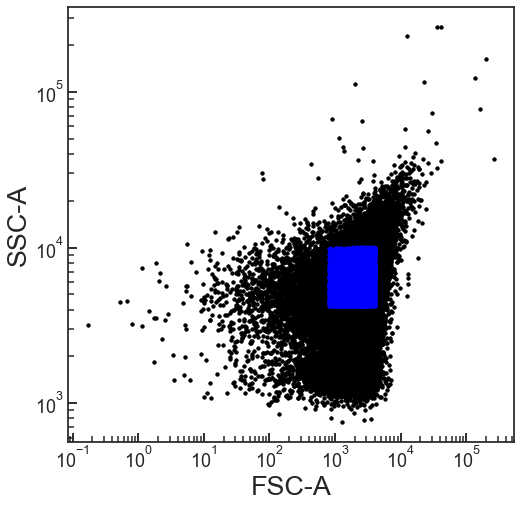

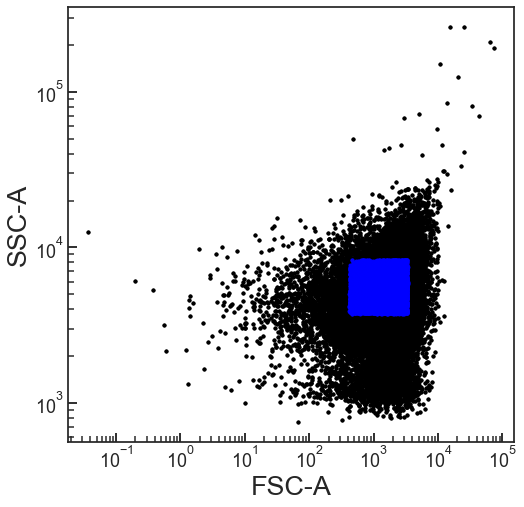

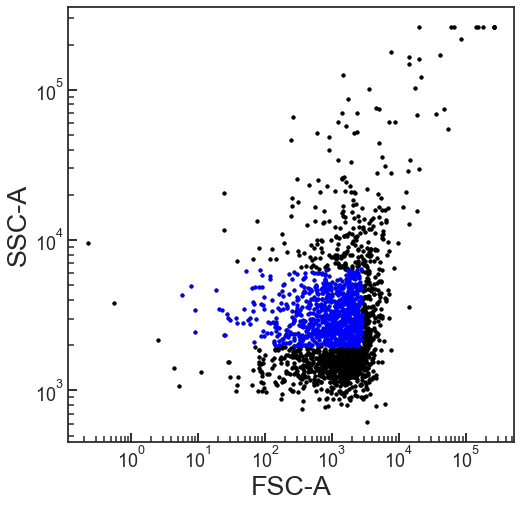

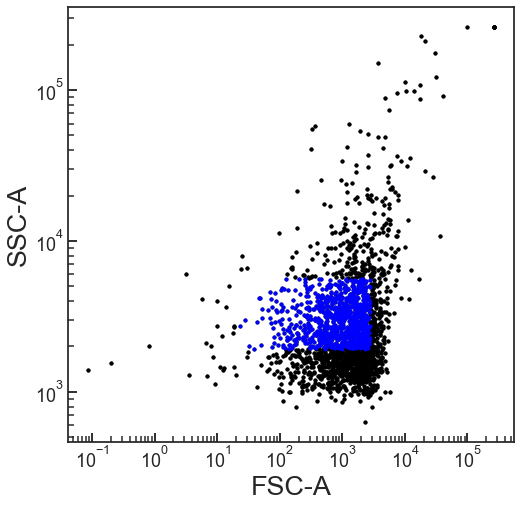

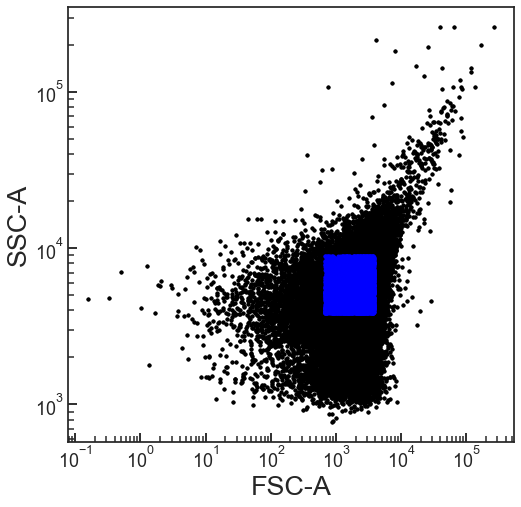

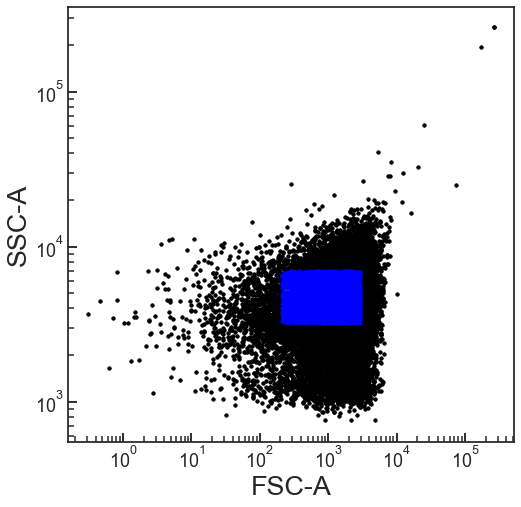

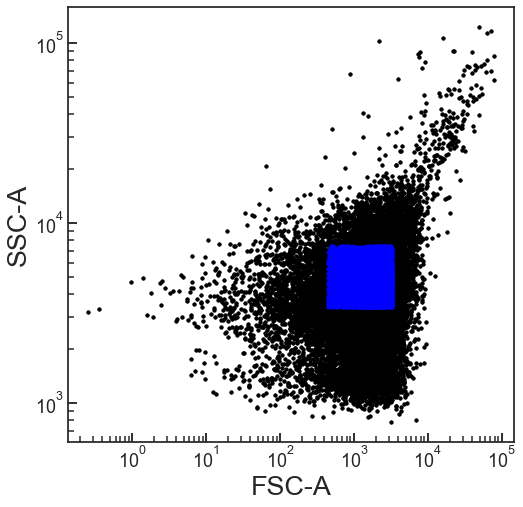

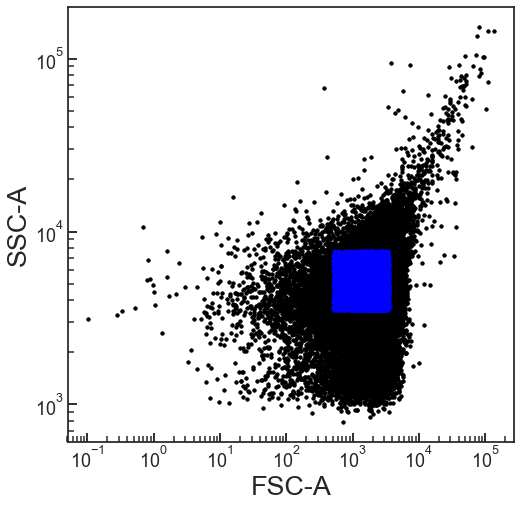

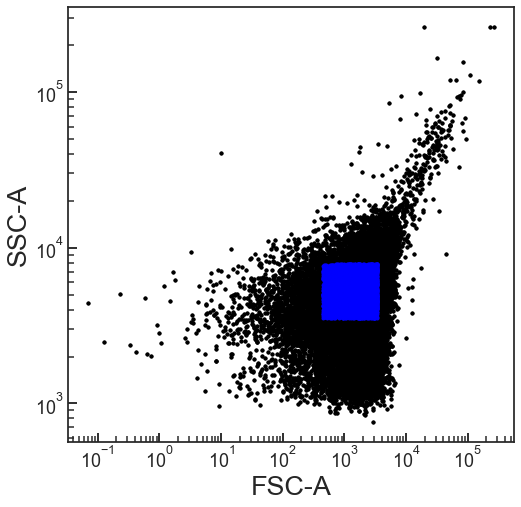

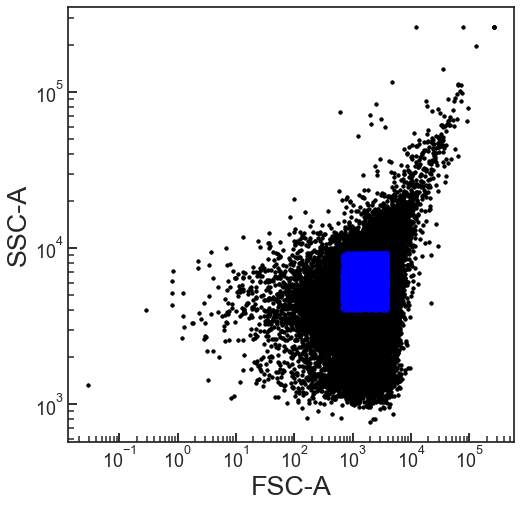

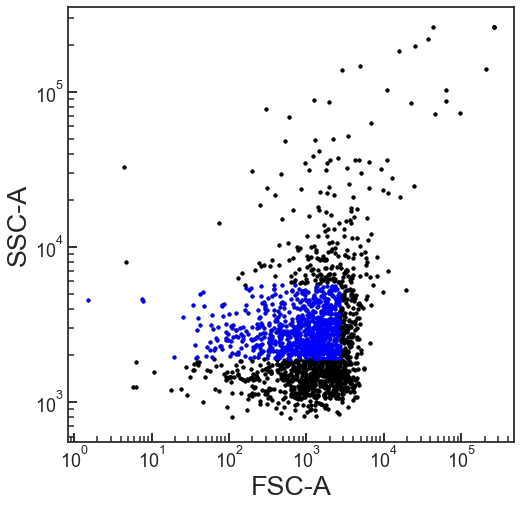

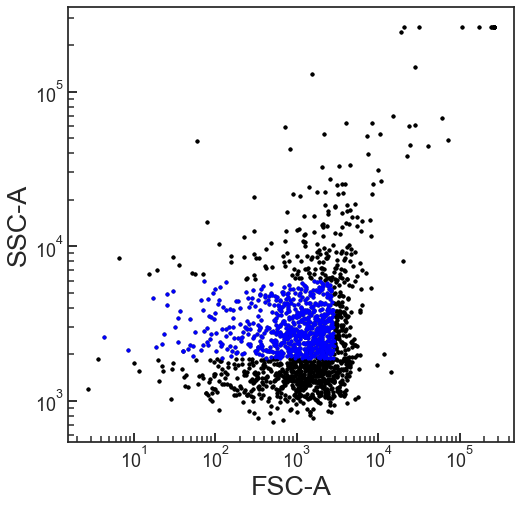

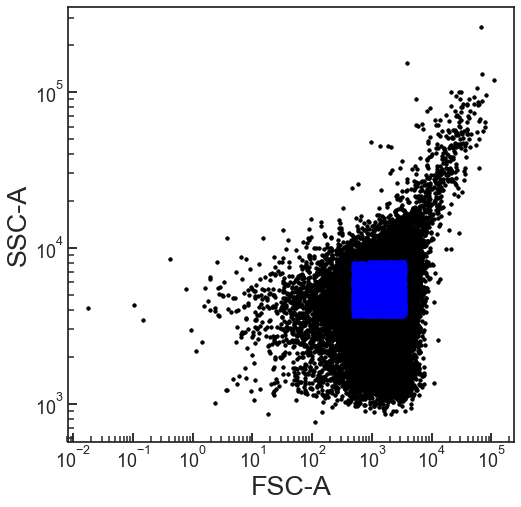

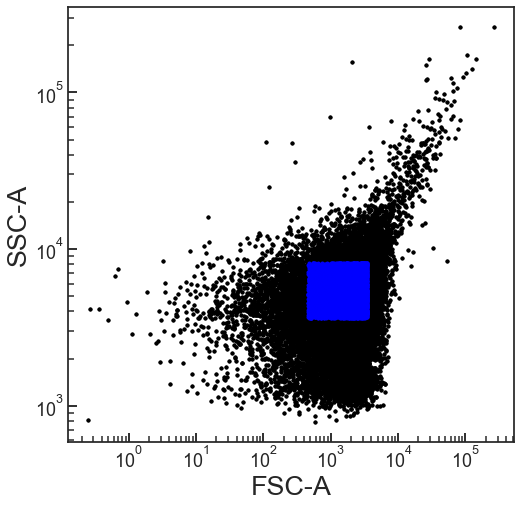

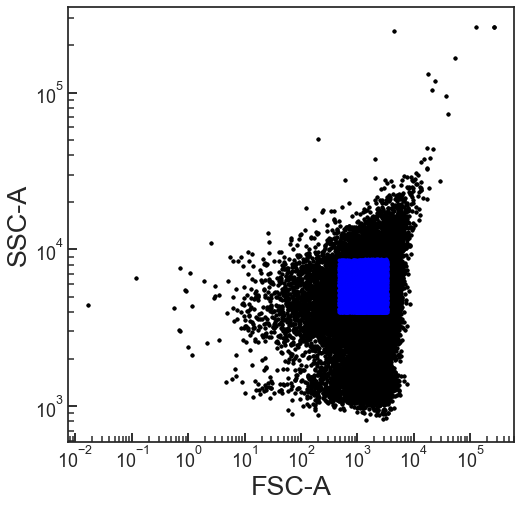

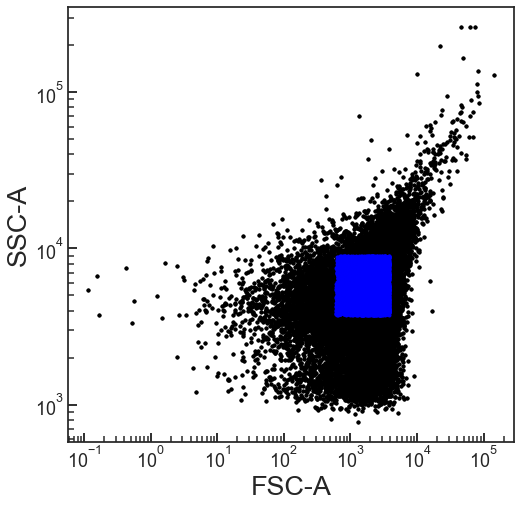

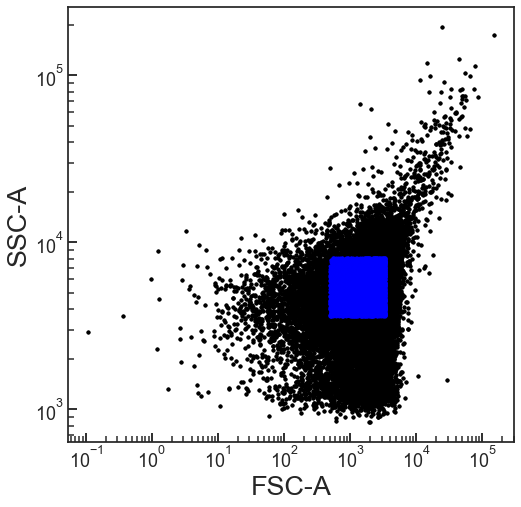

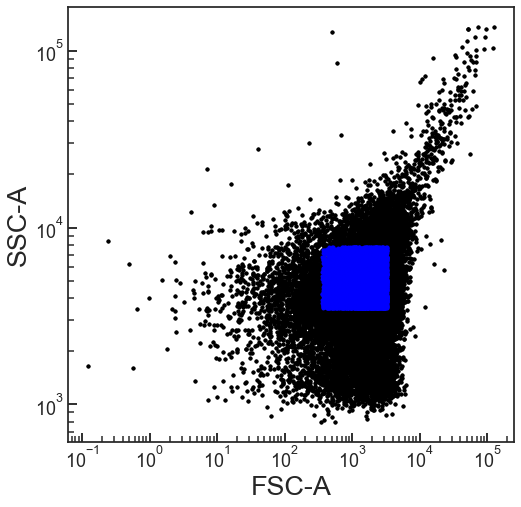

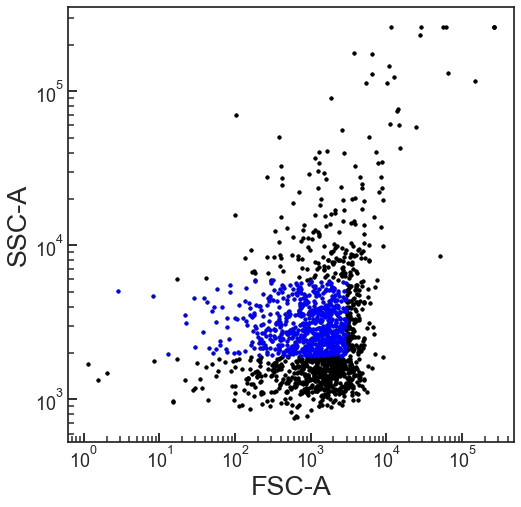

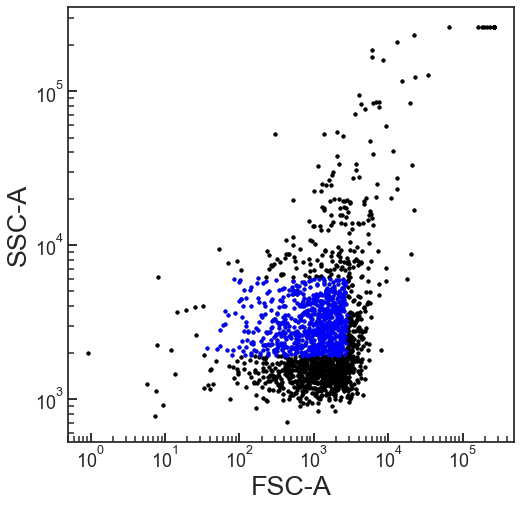

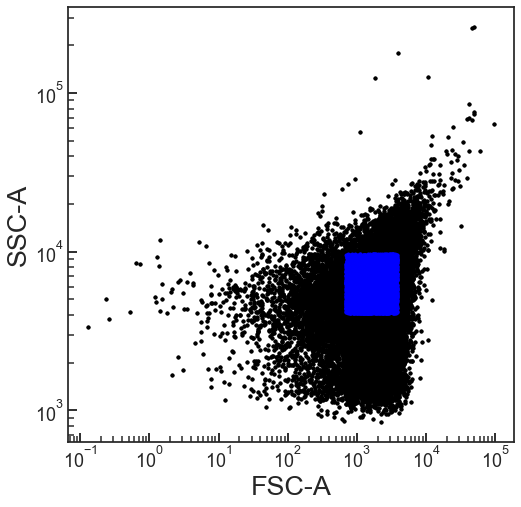

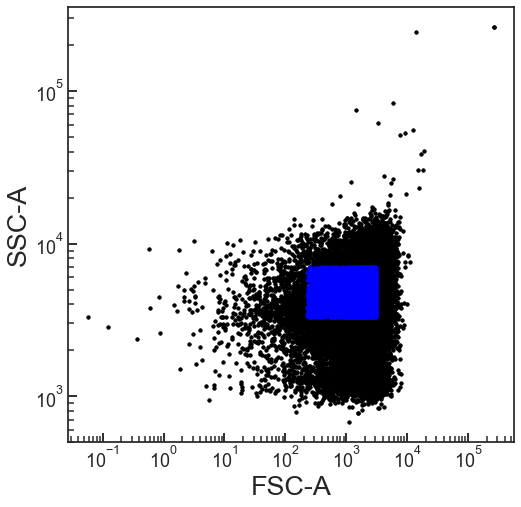

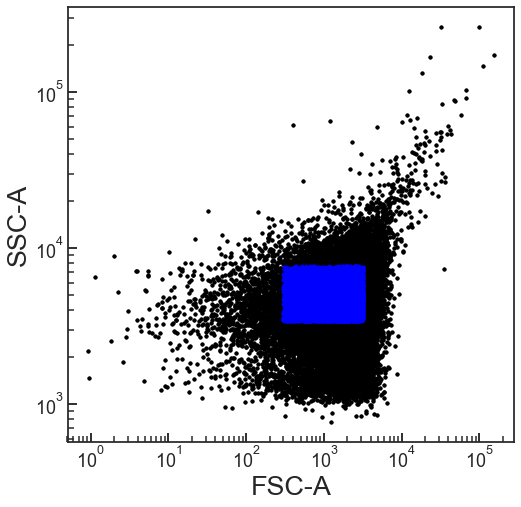

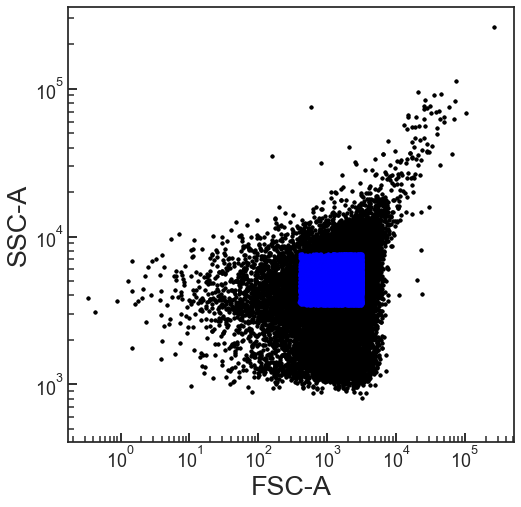

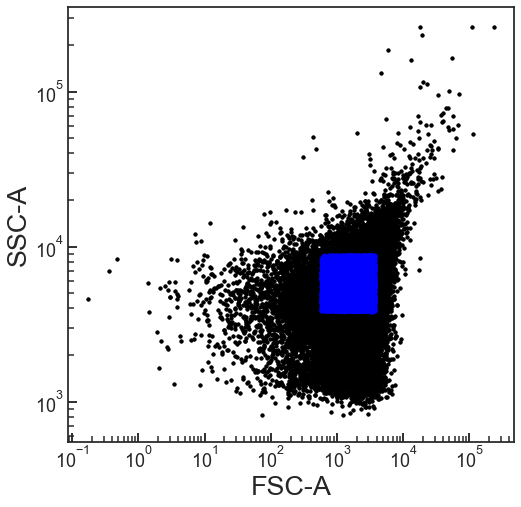

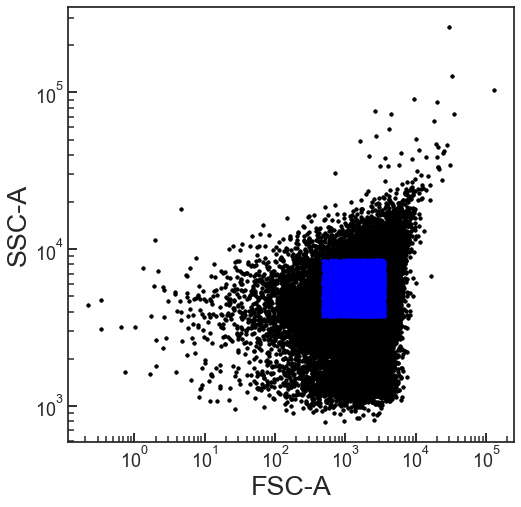

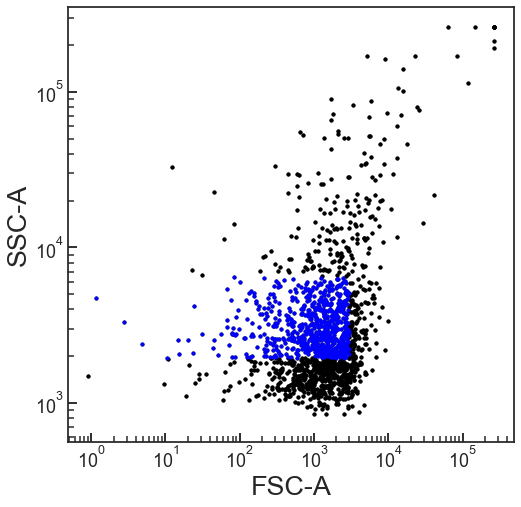

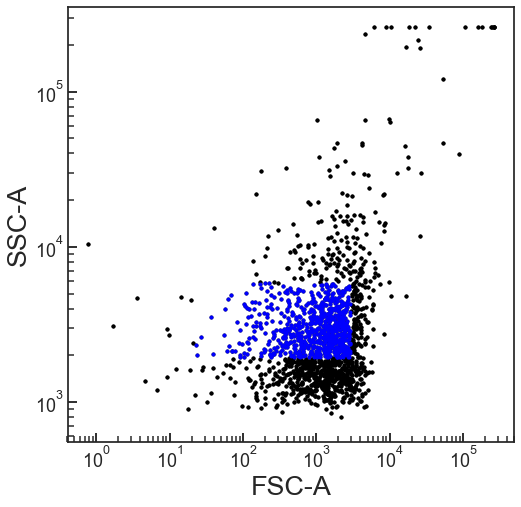

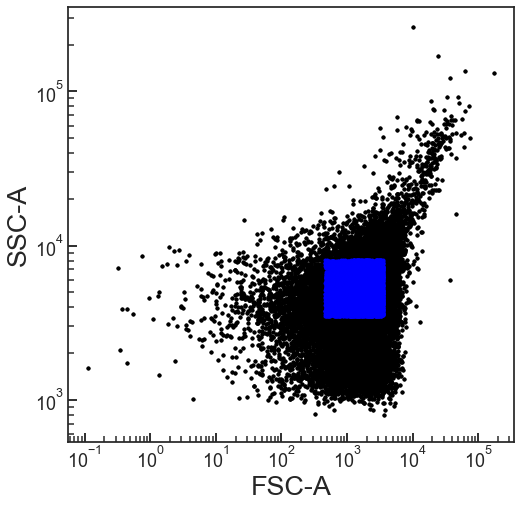

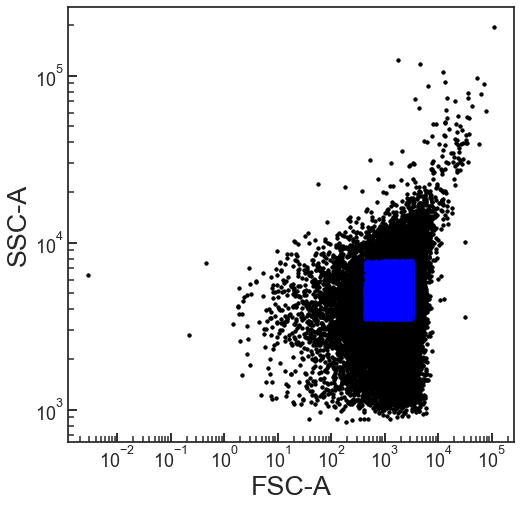

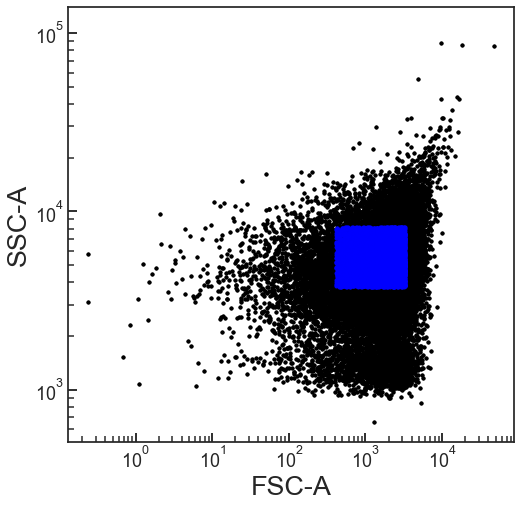

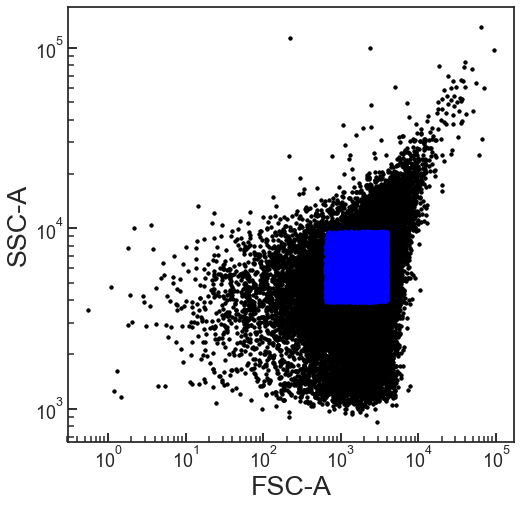

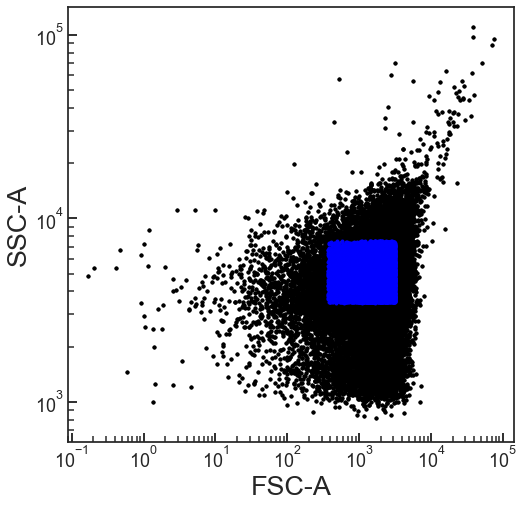

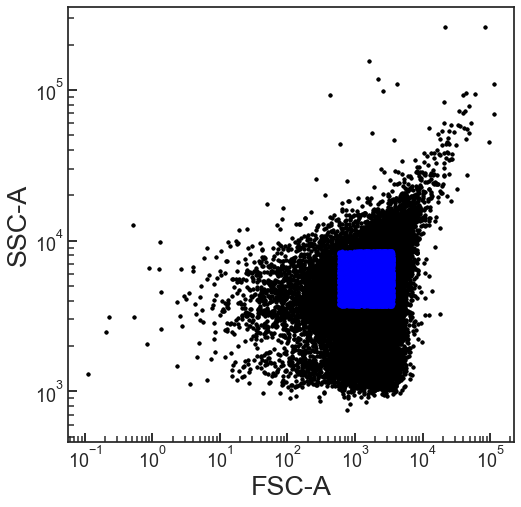

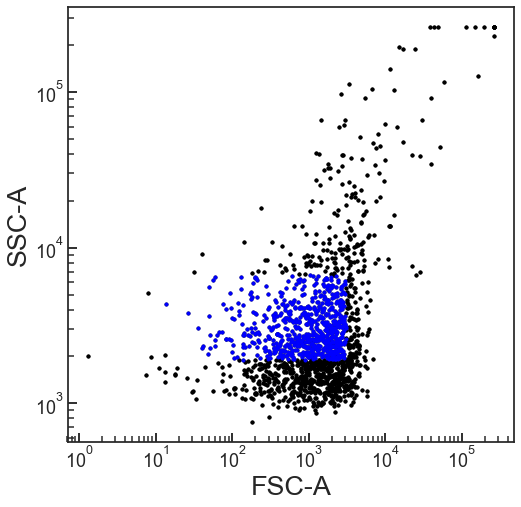

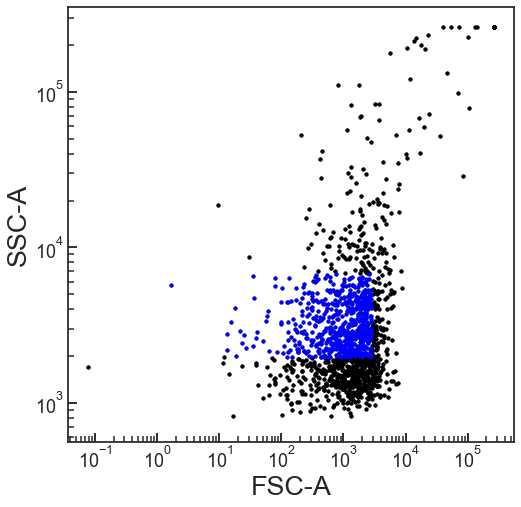

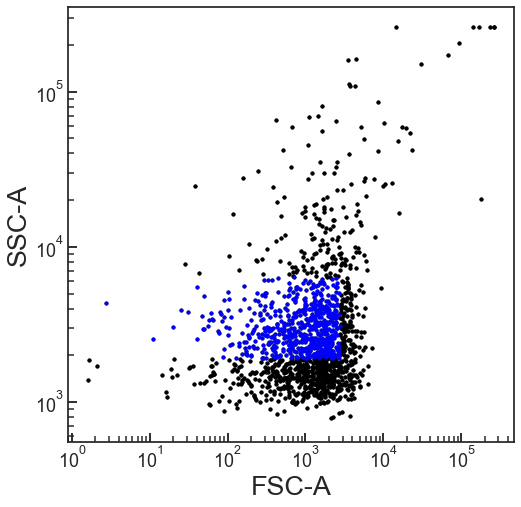

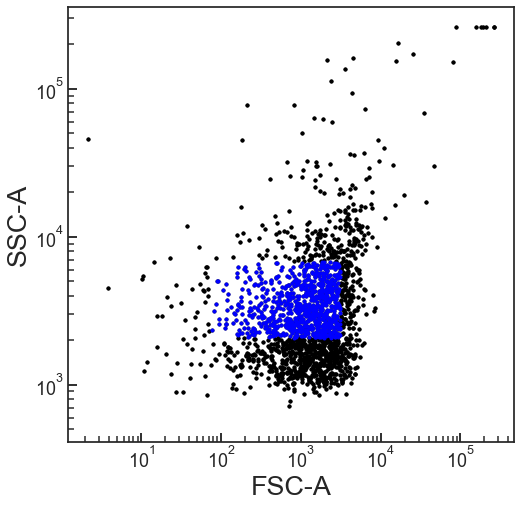

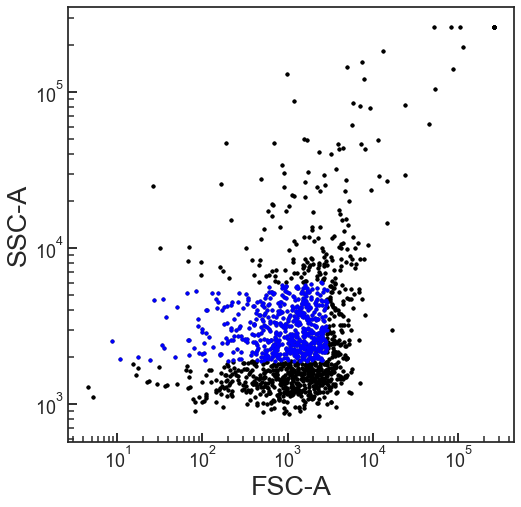

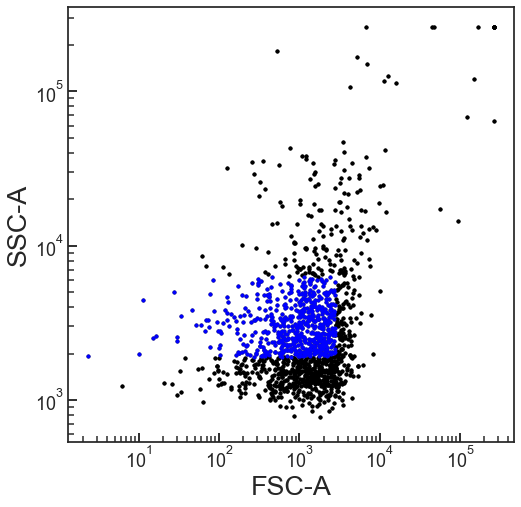

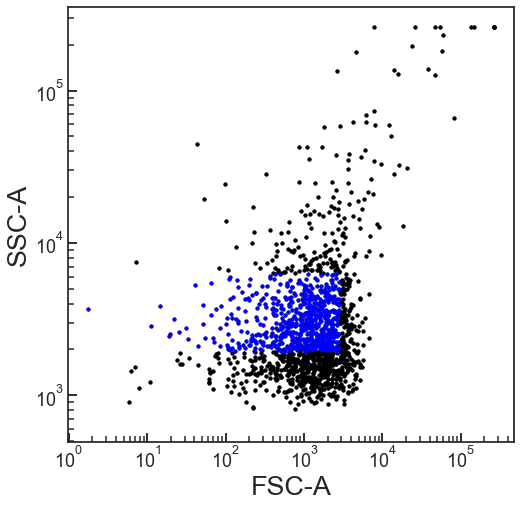

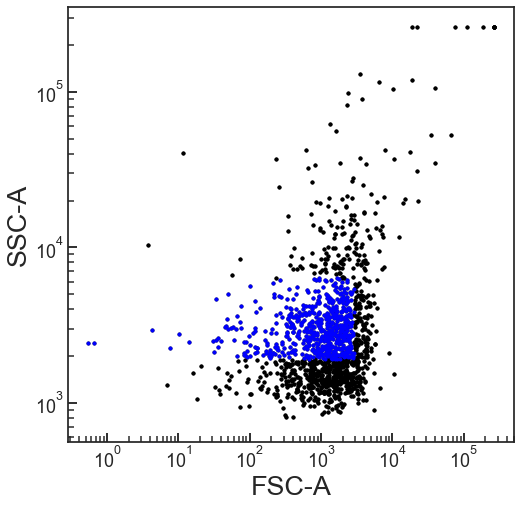

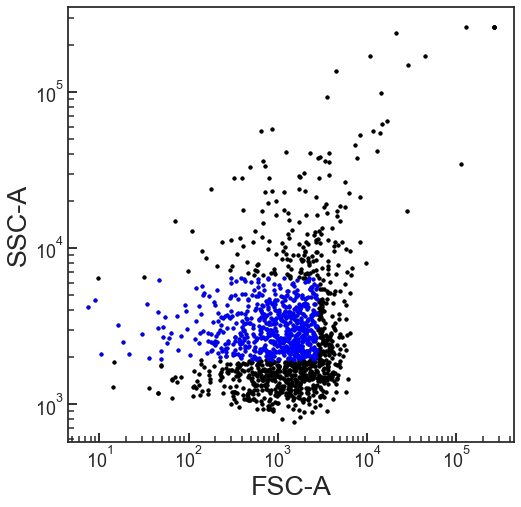

In [36]:
start = time.time()

# Call get_all_gates by pointing to
# 1. your tidy data location (string of file loc)
# 2. where you want gated files to go (string of file loc)
# 3. where you want the plots with the gates to go (string of file loc)
# 4. low percentile (int)
# 5. high percentile (int)
# 6. list of wells you want to use (list of strings)
# 7. first_channel (name must match exactly to tidy column header, str format)
# 8. second_channel (name must match exactly to tidy column header, str format)
get_all_gates('../Data/example_data/tidy/*.csv',
              '../Data/example_data/gated_scatter/',
              '../Data/example_data/gates_scatter/',
             40, 90, wells)
end = time.time()
print(end-start)